In [ ]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def row_norm(x):
    '''
    Return the input normalized so that each row sums to 1. 
    '''
    return x / x.sum(1, keepdims=True)

# Binomial mixture model 

The first model we'll consider is a binomial mixture model. 
$$ y_{pi} \sim \text{Binomial}( n_{pi}, \mu_{pc_i} ) $$
where 
* $p$ indexes observed dimensions, 
* $i$ indexes samples,
* $\mu$ are the centroids (means, i.e. probability of success, of each Binomial cluster)
* $n_{ip}$ is the total count for sample $i$ and dimension $p$, which we will assume is known/observed
* $c_i$ is the cluster assignment for sample $i$

Let's sample some random data under this model

In [ ]:
P = 5 # number of observed dimensions
K = 3 # true number of clusters
N = 800 # number of samples

torch.manual_seed(0)
cluster_means = torch.rand((P,K)) # must be in [0,1]
true_clusters = torch.randint(high = K, size = (N,))

x = cluster_means[:,true_clusters]
n = torch.distributions.poisson.Poisson(torch.full_like(x, 10)).sample()
y = torch.distributions.binomial.Binomial(total_count=n, probs=x).sample()

One straightforward way of visualing the data would be to look at the ratios y/n and perform PCA. 

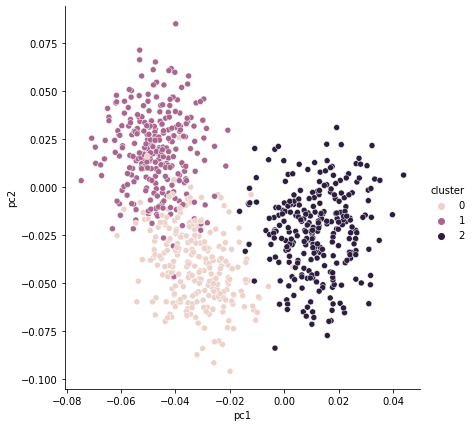

In [ ]:
ratios = y/n
u,s,vh = torch.pca_lowrank( ratios, q = 3, center=True, niter = 5)

df = pd.DataFrame({ "pc1" : vh[:,0], "pc2" : vh[:,1], "cluster" : true_clusters.numpy() } )

_ = sns.pairplot(x_vars = ["pc1"], y_vars = ["pc2"], hue = "cluster", data = df, height=6 )

We see the clusters are reasonably well separated in this case. 

# Fitting using VBEM/CAVI

Now we'll try to use variational Bayes (VB) to fit this model, specifically VB EM also known as coordinate ascent variational inference (CAVI).  

### Task: write the log likelihood [2 points]

Write the log likelihood $ \log P(Y|c,\mu) $ in terms of $y$, $n$, $1[c_i = k]$ and $\mu$. Remember the trick $ P(Y_{pi}|c_i,\mu) = \prod_k P(Y_{pi}|c_i=k)^{1[c_i = k]} $. 

TODO

$$ \log P(Y|c,\mu) = \sum_k{{1[c_i = k]}P(Y_{pi}|c_i=k)}$$


### Task: derive the VB update for mu [4 points]

From class we that the "mean-field" VB update is 
$$ q(\mu) \propto \exp \mathbb{E}_{q(c)}[ \log P(Y|c,\mu) ] $$
Note I'm implicitly assuming a uniform prior on both $c$ and $\mu$, which is nice because we can just ignore them. Each $c_i$ is a discrete random variable so we can write its variational distribution as $q(c_i=k) = r_{ik}$ where $\sum_k r_{ik} = 1$, just like in the EM mixture model. $r_{ik}$ is a "responsibility": how probable is it that sample $i$ came from cluster $k$. Note that 
$$\mathbb{E}_{q(c)}( 1[c_i = k] )= r_{ik}$$
It will also be help to know that the beta(x;a,b) pdf is
$$ x^{a-1}(1-x)^{b-1} $$ 
ignoring the normalizing constant which we don't need here. 

Your task is to derive the update for $$q(\mu)$$. The expression you get should be (proportion to) a beta distribution. 
* start with your expression from the previous task. 
* Take expectations wrt $q(c)$
* Compare what you get to the Beta log pdf, and use this to determine the $a$ and $b$ parameters
* It's probably easiest to work this out with explicit sums over $i$, $p$ and $k$. 
* In the end you should be able to get the parameters of $\mu$ in terms of matrix multiplies with no explicit loops. 

TODO: your derivation here

$$ q(n,c)=q(n)\prod{(q_i(c_i=k))}$$
$$ q(c) ^ {new}\propto \exp \mathbb{E}_{q(n)} \sum{[ c_i\log n_{ip}+ c_i \log p_i  ] } = \prod{ \phi_i^{c_i}} $$
where $\phi_i^{c_i} \propto p_i exp(\mathbb{E}_{q(c)}[\log n_ip)])$ 
$$q(n_{ip}) ^ {new} \propto exp(\mathbb{E}_{q(c)}[(\alpha-1])log n+ \sum c_{i}logn]=Dirichlet(n|\alpha')$$
where $\alpha' = \alpha + \sum \phi_n$since$\mathbb{E}_{q(c)}c_n = \phi_n$

### Task: derive the VB update for c [3 points]

This is quite similiar to the EM update, with the twist that we don't have explicit cluster parameters, just a variational distribution over them. What we need now is: 
$$ q(c) \propto \exp \mathbb{E}_{q(\mu)}[ \log P(Y|c,\mu) ] $$
We'll need the following identities for when $ x \sim \text{Beta}(a,b)$ and corresponding functions: 
$$ \mathbb{E}[\log(x)] = \psi(a) - \psi(a+b) $$ 
and 
$$ \mathbb{E}[\log(1-x)] = \psi(b) - \psi(a+b) $$
where $\psi$ is the [digamma](https://en.wikipedia.org/wiki/Digamma_function) function. In code: 

In [ ]:
def beta_E_log(a,b):
    return torch.digamma(a) - torch.digamma(a + b)

def beta_E_log1mp(a,b):
    return torch.digamma(b) - torch.digamma(a + b)

You'll need to 
* take expectations of the expression from the first task wrt to $q(\mu)$ using the expressions above. 
* appropriately sum over $p$ using a matrix multiplication
* normalize so that $\sum_k r_{ik} = 1$ 

YOUR DERIVATION HERE

### Task: implement the VB updates [3 points]

Using your derivations from above, fill in the updates for $q(\mu)$ and $r = q(c)$. 

In [ ]:
def vb_for_binomial_mix(y, n, K, iterations = 20, seed = 0, verbose = False):
    torch.manual_seed(seed)
    N = y.shape[1]

    r = row_norm(torch.rand((N,K))) # randomly initialize R 
    elbos = []
    for i in range(iterations): # in practice would use a stop criterion like convergence of the elbo
        if verbose: print("Iteration %i" % i)
        q_mu_a = ?  # TODO just these two lines
        q_mu_b = ?

        E_log_mu = beta_E_log(q_mu_a, q_mu_b)
        E_log1m_mu = beta_E_log1mp(q_mu_a, q_mu_b)

        ll = ? # TODO just this line where ll_{ik} = E[log \prod_p P(y_{pi}|n_{pi},c_i=k)]

        logits = ll - ll.logsumexp(axis = 1, keepdim = True) # normalizing r in log space
        r = logits.exp()

        likelihood = (r * ll).sum()
        entropy = -(r * r.log()).sum() + torch.distributions.beta.Beta(q_mu_a, q_mu_b).entropy().sum()
        elbo = likelihood + entropy
        elbos.append(elbo.item())
    return(elbos, r, q_mu_a, q_mu_b)

VB maximises a quantity called the "evidence lower bound" (ELBO), which is the expected likelihood plus the entropy of the variational distribution. This lower bounds the "evidence", i.e. the marginal likelihood of the model with all the latent variables/parameters integrated out. Every step of VBEM should increase the ELBO, if not something is up! 

Text(0, 0.5, 'ELBO')

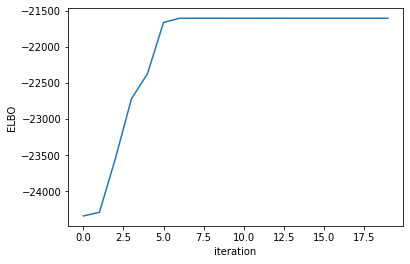

In [ ]:
elbos, r, q_mu_a, q_mu_b = vb_for_binomial_mix(y, n, K = K) # cheating a bit by knowing the true K
assert(abs(elbos[-1] - -21604.8828125) < 1e-6) # make sure this passes
plt.plot(elbos)
plt.xlabel("iteration")
plt.ylabel("ELBO")

## Visualization

Let's check how our clustering looks: 

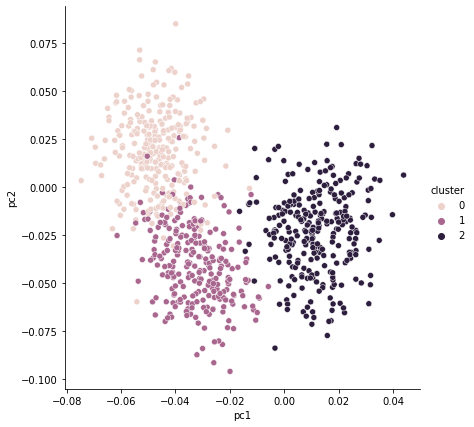

In [ ]:
assignments = r.argmax(axis=1) # get maximum a posteriori cluster assignments

df = pd.DataFrame({ "pc1" : vh[:,0], "pc2" : vh[:,1], "cluster" : assignments.numpy() } )

_ = sns.pairplot(x_vars = ["pc1"], y_vars = ["pc2"], hue = "cluster", data = df, height=6 )

VB has found the clusters pretty well qualitatively at least. We can assess how well this agrees with the ground truth clustering using the adjust Rand index: 

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(true_clusters, assignments.numpy())

0.9630755278504731

I get 0.96 for this which is pretty good. 

## Real data: RNA splicing

We'll analyze RNA splicing in individual mouse neurons (from the [Tabula Muris](https://tabula-muris.ds.czbiohub.org/) project) quantified via our [LeafCutter tool](https://www.nature.com/articles/s41588-017-0004-9). In short, we have counts corresponding to how much each exon-exon junction (just "junction" in the following) is used relative to a carefully defined group of neighbors (the splicing "cluster"), which gives the total counts. 

Here $y_{ip}$ is the number of spliced reads for junction $p$ in cell $i$. $n_{ip}$ is the number of spliced reads aligning to any junction in the group of junctions ("splice cluster" in the LeafCutter paper terminology) that junction $p$ is in. 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datadir = "/content/drive/MyDrive/ML4fungen/Assignment 4/data/" # may need to change this
y_real = np.load(datadir + "junc_counts.npy")
n_real = np.load(datadir + "denoms.npy")
y_real.shape

(13406, 3396)

Here we have $P=13k$ junctions and $N=3396$ cells. This is single cell data so it's pretty sparse: 79% of entries are effectively missing since the total count is 0: 

In [ ]:
(n_real == 0).mean()

0.7909590391377593

In [ ]:
y_real_tensor = torch.tensor(y_real, dtype = torch.float) 
n_real_tensor = torch.tensor(n_real, dtype = torch.float) 
_, r, q_mu_a, q_mu_b = vb_for_binomial_mix(y_real_tensor, n_real_tensor, K = 30, verbose = True) 

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19


Text(0, 0.5, '# cells')

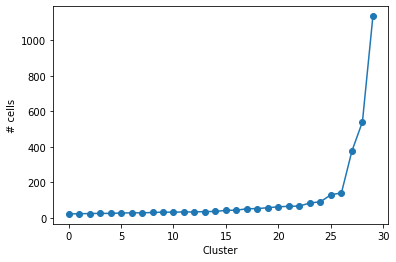

In [ ]:
assignments = r.argmax(axis=1) # get maximum a posteriori cluster assignments
from collections import Counter
cluster_counts = Counter(assignments.numpy())
plt.plot(sorted(list(cluster_counts.values())), '-o')
plt.xlabel("Cluster")
plt.ylabel("# cells")

With this random seed at least we end up with 3 quite large clusters and many smaller ones. 

# Binomial matrix factorization

Clustering can be appropriate in some circumstances, but it can't effectively model multiple continuous axis of latent variation in data. Mixed membership and matrix factorization models are much more effective for this. Here we'll explore using a binomial matrix factorization model fit using a different type of VB inference: stochastic variational inference.

## Task: add the entropy term [2 points]

[Wikipedia](https://en.wikipedia.org/wiki/Normal_distribution) will tell you what the (differential) entropy of a Gaussian is. From the code you can hopefully work out what term you should be adding at the "TODO" below. 

In [ ]:
import torch
import torch.nn
from torch.distributions import Normal

class GaussianVariationalDist(torch.nn.Module):
    """ Class representing a diagonal covariance Gaussian over some tensor """
    def __init__(self, size, m=None, log_s=None):
        super(GaussianVariationalDist, self).__init__()
        if m is None:
            # Initialize the mean for the unconstrained variational distribution.
            m = torch.randn(size)

        if log_s is None:
            # Initialize the log standard deviation for the unconstrained variational distribution.
            log_s = torch.randn(size)

        # Variational parameters
        self.m = torch.nn.Parameter(m)
        self.log_s = torch.nn.Parameter(log_s)

        # Dimension of the variational parameters
        self.size = size

    def dist(self):
        """ Unconstrained variational distribution -- a Gaussian always.
        If the parameter (theta) of interest has positive support,
        we would place a Normal variational distribution on log(theta)."""
        return Normal(self.m, self.log_s.exp())

    def rsample(self, n=torch.Size([])):
        """ Sample from the distribution. The same as:
        self.m + torch.randn(n) * self.log_s.exp() """
        return self.dist().rsample(n)

    def log_q(self, x):
        """ log q(x) i.e. the log pdf of x under this distribution """
        return self.dist().log_prob(x).sum()

    def forward(self):
        """ Forward just means sampling from the distribution """
        return self.rsample()

class BinomialMF(torch.nn.Module):
    """ Model Y ~ Binomial(n, sigma(A @ B + mu)) """ 
    def __init__(self, N, P, K, A_prior_sd = 1., B_prior_sd = 1., mu_prior_sd = 3.):
        super(BinomialMF, self).__init__()

        # variational distributions
        self.qA = GaussianVariationalDist((P,K))
        self.qB = GaussianVariationalDist((K,N))
        self.qmu = GaussianVariationalDist(P)

        # priors
        self.pA = Normal(0, A_prior_sd)
        self.pB = Normal(0, B_prior_sd)
        self.pmu = Normal(0, mu_prior_sd)

    def forward(self):
        A = self.qA() # sample
        B = self.qB()
        mu = self.qmu()

        # easiest to calculate this here since otherwise we would need to return A, B, mu
        log_prior = self.pA.log_prob(A).sum() + self.pB.log_prob(B).sum() + self.pmu.log_prob(mu).sum()

        return A @ B + mu[:,None], log_prior

def svi(binomialMF, optim, y, n, iterations = 500, print_every = 1000):
    elbos = []
    P,N = y.shape
    for i in range(iterations):
        p, log_prior = binomialMF()
        bin = torch.distributions.Binomial(total_count = n, logits = p)
        log_likelihood = bin.log_prob(y).sum()
        entropy = 0
        for q in binomialMF.modules(): 
            if type(q) == GaussianVariationalDist: 
                entropy += ## TODO

        elbo = log_likelihood + log_prior + entropy
        loss = - elbo / (N * P)
        if (i+1) % print_every == 0: print("Iteration: %i ELBO: %.4g" % (i+1, elbo.item()))

        elbos.append(elbo.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
    return elbos


Let's run this on our toy simulated data. 

Text(0, 0.5, 'ELBO')

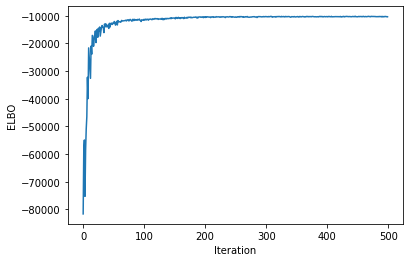

In [ ]:
P,N = y.shape
torch.manual_seed(0)
binomialMF = BinomialMF(N, P, K = 2) # just two latent dimensions
optim = torch.optim.Adam(binomialMF.parameters(), lr=.1)
elbos = svi(binomialMF, optim, y, n)
assert(abs(elbos[-1] - -8094.275390625) < 1e-3) # make sure this passes
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")

We can plot the latent factors, and because we used VB we can additionally show the (considerable!) uncertainty in the estimates. 

<ErrorbarContainer object of 3 artists>

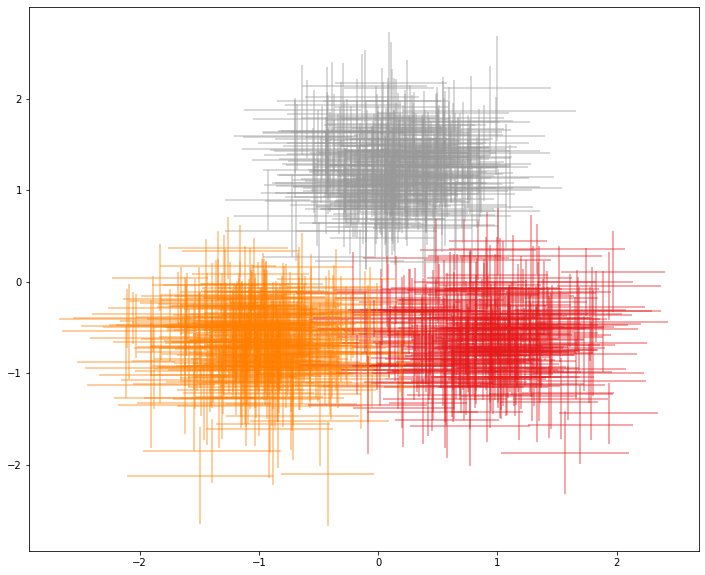

In [ ]:
from matplotlib import colors

Bm = binomialMF.qB.m.detach().numpy() # mean(B)
Bs = binomialMF.qB.log_s.exp().detach().numpy() # standard deviations

plt.figure(figsize=(12,10))
colormap = plt.cm.get_cmap('Set1', K)(range(K), alpha=0.5)
colors = colormap[true_clusters.numpy(),:]
plt.errorbar(Bm[0,:], Bm[1,:], xerr=Bs[0,:], yerr=Bs[1,:], fmt=' ', ecolor = colors)

Now we can run on the real splicing data. 

Iteration: 30 ELBO: -1.017e+08
Iteration: 60 ELBO: -6.637e+07
Iteration: 90 ELBO: -6.17e+07
Iteration: 120 ELBO: -6.003e+07
Iteration: 150 ELBO: -5.851e+07
Iteration: 180 ELBO: -5.803e+07
Iteration: 210 ELBO: -5.698e+07
Iteration: 240 ELBO: -5.616e+07
Iteration: 270 ELBO: -5.562e+07
Iteration: 300 ELBO: -5.495e+07
Iteration: 330 ELBO: -5.445e+07
Iteration: 360 ELBO: -5.405e+07
Iteration: 390 ELBO: -5.37e+07
Iteration: 420 ELBO: -5.34e+07
Iteration: 450 ELBO: -5.303e+07
Iteration: 480 ELBO: -5.287e+07


Text(0, 0.5, 'ELBO')

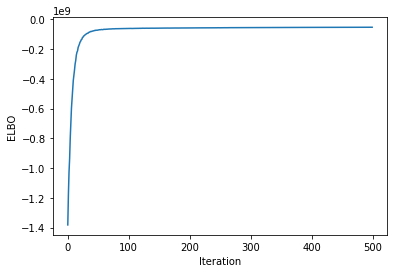

In [ ]:
P,N = y_real.shape
binomialMF = BinomialMF(N, P, K = 2) # just two latent dimensions
optim = torch.optim.Adam(binomialMF.parameters(), lr=.1)

binomialMF.to("cuda") # we'll do this on the GPU for speed
elbos = svi(binomialMF, optim, y_real_tensor.to("cuda"), n_real_tensor.to("cuda"), print_every = 30)
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")

Let's plot the results. 

Text(0, 0.5, 'Latent factor 2')

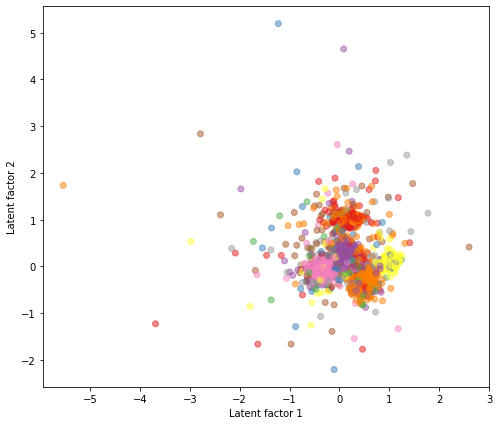

In [ ]:
from matplotlib import colors

Bm = binomialMF.qB.m.detach().cpu().numpy() # mean(B)
Bs = binomialMF.qB.log_s.exp().cpu().detach().numpy() # standard deviations

plt.figure(figsize=(8,7))
colormap = plt.cm.get_cmap('Set1', 30)(range(30), alpha=0.5)
colors = colormap[assignments.numpy(),:]
plt.scatter(Bm[0,:], Bm[1,:], color = colors)
plt.xlabel("Latent factor 1")
plt.ylabel("Latent factor 2")

We see there are several main clusters of cells and then some significant outliers. A cleaner visualization could likely be obtained by using a larger number of latent factors and then applying a nonlinear dimensionality reduction technique like [tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) or [UMAP](https://arxiv.org/abs/1802.03426). 

## Exploratory tasks

### Does initialization matter? [2 points]

For the real data, mask out 10% of the non-missing (i.e. where n_real > 0) entries as test data. Write code to impute (predict) these missing values from the fit models. Try 10 different random restarts (initializations) of each model. How consistent is the imputation accuracy across restarts? How consistent is the final ELBO across restarts? Do models with higher ELBO tend to result in better imputation accuracy? 

### Finding the best model [2 points]

For the real data, mask out 10% of the non-missing (i.e. where n_real > 0) entries as test data. Write code to impute (predict) these missing values from the fit models. Fit both models (mixture model and matrix factorization) with varying $K$ up to $K=10$, impute the missing values and assess imputation performance (either in terms of binomial loss or mean absolute error in predicted ratio y/n). Which model can better impute the missing values? What values of K work best? Do models with higher ELBO tend to result in better imputation accuracy? 

### Extending the binomial mixture [2 points]

Extend the model so that $c_i \sim Discrete( \pi )$ and $ \pi \sim Dirichlet( [ 1/K ... 1/K ])$ (for large $K$ this is an approximation to a "[Dirichlet process](https://en.wikipedia.org/wiki/Dirichlet_process)"). Add VB inference over $\pi$. Does this change the distribution of sizes of clusters you get on the real data?

### Extending the binomial MF [2 points]

Extend the model to learn the variances of the prior on $B$. Specifically model $P(B_{ki}|v_k) = N(B_{ki};0,v_k)$ where $v_k$ is a per factor variance. Work with $t_k = \log v_k$. Put a normal prior and variational distribution on $t_k$ (corresponding to log normals on $v_k$). Extend the SVI to learn $q(v)$. This should behave like [automatic relevance determination](https://scikit-learn.org/stable/modules/linear_model.html#automatic-relevance-determination-ard) (ARD) to turn off unnecessary factors. Investigate whether this is effective, e.g. by setting $K$ very large and comparing the inferred $B$ with and without ARD. 
